## Sentiment analysis
Naive Bayes models are very useful when we want to analyze sentiment, classify texts into topics or recommendations, as the characteristics of these challenges meet the theoretical and methodological assumptions of the model very well.

In this project you will practice with a dataset to create a review classifier for the Google Play store.

In [25]:
# Step 0. Import libraries, custom modules and logging
# Basics ---------------------------------------------------------------
#import logging
#import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import (
                        GaussianNB,
                        MultinomialNB,
                        BernoulliNB
)
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer)
from sklearn.metrics import (accuracy_score, ConfusionMatrixDisplay)
import re
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
nltk.download("stopwords")
stop_words = stopwords.words("english")

# Función para quitar los stopwords del data frame
def remove_stopwords(text):
    clean_text = []
    text = text.lower()
    if text is not None:
        words = text.split()
        for word in words:
            if word not in stop_words:
                clean_text.append(word)
        return " ".join(clean_text)
    else:
        return None


def remove_symbols(text):
    if text is not None:
        text = re.sub(r'''[.,?*&'"+${}-]''','',text) # Sub sustituir 
        return text
    else:
        return None

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 1 Create data frame
# 1.1 Read from source and get basic info
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


In [3]:
df_raw.sample(10)

,package_name,review,polarity
437,com.whatsapp,a avid fan of wapp; thats what we call it.. ...,1
326,com.viber.voip,improve... please add a feature where we can ...,0
216,com.supercell.clashofclans,nyc 1 u guys should apply some same strategy...,0
232,com.supercell.clashofclans,no longer a casual game the current version o...,1
71,com.twitter.android,really great! twitter is an amazing app which...,0
168,com.imangi.templerun2,????? hanging so much even i am using higher ...,0
789,org.mozilla.firefox,"the authority firefox is firefox, after wande...",1
239,com.android.chrome,not responding occasionally sometimes chrome ...,0
520,com.dropbox.android,its not safe it has a link to gallery and fil...,0
367,com.google.android.talk,would like to see who are currently online? p...,0


In [4]:
# 1.2 Process Data 
# En base al texto determinar si el contenido es ham o spam
df_interim=(
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(" ", "_")
        .str.lower(), axis=1
    )   
    .drop(["package_name"], axis=1)
)
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    891 non-null    object
 1   polarity  891 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.1+ KB


In [5]:
df = df_interim.copy()
df["review_clean"] = df["review"].apply(lambda x: remove_stopwords(x))
df["review_clean"] = df["review_clean"].apply(lambda x: remove_symbols(x))
df["review_clean"] = df["review_clean"].str.replace(":", "")
df["review_clean"] = df["review_clean"].str.replace("!", "")
df["review_clean"] = df["review_clean"].str.replace("(", "")
df["review_clean"] = df["review_clean"].str.replace(")", "")

In [6]:
df_train, df_test = train_test_split(df, test_size=.2, stratify=df["polarity"], random_state=2024)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 257 to 734
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review        712 non-null    object
 1   polarity      712 non-null    int64 
 2   review_clean  712 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.2+ KB


In [7]:
df_train["polarity"].value_counts()

polarity
0    467
1    245
Name: count, dtype: int64

In [8]:
df_train.sample(10)

,review,polarity,review_clean
321,no ringing tone whenever i call someone it sh...,0,ringing tone whenever call someone shows ringi...
304,forgot my old wechat password! i want to reop...,0,forgot old wechat password want reopen old wec...
210,new update sucks.... also my base isn't going...,0,new update sucks also base going ipad cause su...
807,better background playback and 'new tab' posi...,1,better background playback new tab position fi...
401,two stars cuz after the update it isnt workin...,0,two stars cuz update isnt working properly rem...
133,booster should be internet independent why in...,0,booster internet independent internet connecti...
26,not supported my phon galaxy core i have been...,0,supported phon galaxy core use face book last ...
757,please add option to provide pdf versions to...,0,please add option provide pdf versions downloa...
103,doesn't work challenge page fails to load. it...,0,work challenge page fails load secure even can...
871,classic game ruined by ads. uninstalled this ...,1,classic game ruined ads uninstalled one classi...


In [9]:
X_train= df_train["review_clean"].reset_index(drop=True)
y_train = df_train["polarity"].reset_index(drop=True)
X_test = df_test["review_clean"].reset_index(drop=True)
y_test = df_test["polarity"].reset_index(drop=True)

In [10]:
count_vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer(sublinear_tf=True)
X_train_vec = count_vectorizer.fit_transform(X_train).toarray()
X_test_vec = count_vectorizer.transform(X_test).toarray()
X_train_vec

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
# Gaussian Naive Bayes Model
model_gnb = GaussianNB()
model_gnb.fit(X_train_vec, y_train)

GaussianNB()

In [12]:
y_pred_gnb = model_gnb.predict(X_test_vec)
print(f'accuracy: {accuracy_score(y_test, y_pred_gnb)}')

accuracy: 0.7653631284916201


In [13]:
# Model MultinomialNB
model_mnb = MultinomialNB()
model_mnb.fit(X_train_vec, y_train)

MultinomialNB()

In [14]:
y_pred_mnb = model_mnb.predict(X_test_vec)
print(f'accuracy: {accuracy_score(y_test, y_pred_mnb)}')

accuracy: 0.7988826815642458


In [15]:
# BernoulliNB
model_bnb = BernoulliNB()
model_bnb.fit(X_train_vec, y_train)

BernoulliNB()

In [16]:
y_pred_bnb = model_bnb.predict(X_test_vec)
print(f'accuracy: {accuracy_score(y_test, y_pred_bnb)}')

accuracy: 0.7430167597765364


In [17]:
# The best model was MultinomialNB so we will optimize it
from sklearn.model_selection import RandomizedSearchCV
hyperparams = {
    "alpha": np.linspace(0.01, 10.0, 200),
    "fit_prior": [True, False]
}

# We initialize the random search
random_search = RandomizedSearchCV(model_mnb, hyperparams, n_iter = 50, scoring = "accuracy", cv = 5, random_state = 42)
random_search

RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=50,
                   param_distributions={'alpha': array([ 0.01      ,  0.06020101,  0.11040201,  0.16060302,  0.21080402,
        0.26100503,  0.31120603,  0.36140704,  0.41160804,  0.46180905,
        0.51201005,  0.56221106,  0.61241206,  0.66261307,  0.71281407,
        0.76301508,  0.81321608,  0.86341709,  0.91361809,  0.9638191 ,
        1.0140201 ,  1.06422111,  1.11442211,  1.1646231...
        8.54417085,  8.59437186,  8.64457286,  8.69477387,  8.74497487,
        8.79517588,  8.84537688,  8.89557789,  8.94577889,  8.9959799 ,
        9.0461809 ,  9.09638191,  9.14658291,  9.19678392,  9.24698492,
        9.29718593,  9.34738693,  9.39758794,  9.44778894,  9.49798995,
        9.54819095,  9.59839196,  9.64859296,  9.69879397,  9.74899497,
        9.79919598,  9.84939698,  9.89959799,  9.94979899, 10.        ]),
                                        'fit_prior': [True, False]},
                   random_state=42, scoring='accuracy')

In [20]:
random_search.fit(X_train_vec, y_train)

print(f"Best hyperparameters: {random_search.best_params_}")

Best hyperparameters: {'fit_prior': False, 'alpha': np.float64(1.917638190954774)}


In [24]:
model = MultinomialNB(alpha = 1.917638190954774, fit_prior = False)
model.fit(X_train_vec, y_train)
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)
aso= accuracy_score(y_test, y_pred)
asm = accuracy_score(y_test, y_pred_mnb)
display(f"MultinomialNB accuracy score: {asm}")
display(f"Oprimized MultinomialNB accuracy score: {aso}")

'MultinomialNB accuracy score: 0.7988826815642458'

'Oprimized MultinomialNB accuracy score: 0.7988826815642458'

The optimized algorithm had the same accuracy score so this step is not needed. 

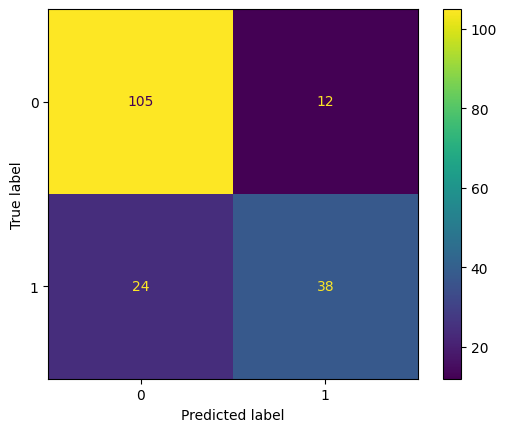

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)